In [1]:
import os, sys
root_path = os.path.abspath('.').split('jupyters')[0]
sys.path.append(root_path)

In [2]:
import json
import argparse
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
import simulator as sim

In [3]:
class Spatial_transformer_regressor(tf.keras.layers.Layer):
    def __init__(self, num_param):
        super(Spatial_transformer_regressor, self).__init__()
        self.regressor = tf.keras.Sequential([
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(), 
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.BatchNormalization(),   
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_param),
        ])

    def call(self, correlation):
        correlation = tf.reshape(correlation, [-1,16,16,256])
        return self.regressor(correlation)

In [4]:
def gen_motion_parameter(shape):
    while True:
        yield (tf.random.uniform(shape) - 0.5) * 2 * 0.2

In [5]:
gen = partial(gen_motion_parameter, (9,2))
ds = tf.data.Dataset.from_generator(gen, output_types=tf.float32)

In [6]:
def data_process(motion_parameters, axay, map_size):
    motion_parameters = motion_parameters.numpy()
    bxby = sim.get_tgt_from_src(motion_parameters, axay, map_size)
    axybxy = np.concatenate([axay, bxby], axis = -1)
    correlations = sim.generate_correlations(axybxy, map_size)
    return motion_parameters, correlations

In [7]:
axay = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                           [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                           [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
map_size = (16, 16)
axay = axay*(map_size[1]-1, map_size[0]-1)
axay = axay.astype(np.int32)

py_func = partial(data_process, axay = axay, map_size = map_size)

In [8]:
def map_function(motion_paramters):
    return tf.py_function(py_func, [motion_paramters], [tf.float32, tf.float32])

In [9]:
ds = ds.map(map_function)
ds = ds.batch(16)

In [10]:
for mp, corr in ds.take(1):
    print(mp.shape)
    print(corr.shape)

(16, 9, 2)
(16, 16, 16, 16, 16)


In [11]:
regressor = Spatial_transformer_regressor(18)

In [12]:
def loss_fn(pred, label):
    loss = tf.sqrt(tf.reduce_sum(tf.pow(pred - label, 2), axis=[-1, -2]))
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [13]:
i = 0
x = []
x_loss = []
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
for epoch in range(20000):
    i+= 1
    x.append(i)
    for mp, correlations in ds.take(1):
        with tf.GradientTape() as tape:
            pred = regressor(correlations)
            pred = tf.reshape(pred, [-1, 9, 2])
            loss = loss_fn(pred, mp)
            x_loss.append(loss)
        gradients = tape.gradient(loss, regressor.trainable_variables)
        optimizer.apply_gradients(zip(gradients, regressor.trainable_variables)) 
        if i % 100 == 0:
            print(i, "iter loss : ", loss.numpy())

100 iter loss :  0.4900506
200 iter loss :  0.49436042
300 iter loss :  0.4935472
400 iter loss :  0.48306155
500 iter loss :  0.493254
600 iter loss :  0.47798002
700 iter loss :  0.46125975
800 iter loss :  0.49761203
900 iter loss :  0.48447996
1000 iter loss :  0.49546596
1100 iter loss :  0.4746144
1200 iter loss :  0.48263854
1300 iter loss :  0.4766081
1400 iter loss :  0.49071753
1500 iter loss :  0.46363997
1600 iter loss :  0.4829491
1700 iter loss :  0.48769325
1800 iter loss :  0.50938743
1900 iter loss :  0.5034105
2000 iter loss :  0.48691016
2100 iter loss :  0.4758135
2200 iter loss :  0.48507568
2300 iter loss :  0.4715015
2400 iter loss :  0.51024127
2500 iter loss :  0.48510873
2600 iter loss :  0.4809578
2700 iter loss :  0.4575867
2800 iter loss :  0.4896366
2900 iter loss :  0.4927686
3000 iter loss :  0.50103676
3100 iter loss :  0.4872526
3200 iter loss :  0.4684784
3300 iter loss :  0.48500448
3400 iter loss :  0.47471148
3500 iter loss :  0.45821714
3600 iter 

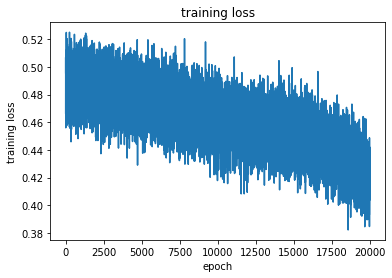

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(122)
ax1.title.set_text("training loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("training loss")
ax1.plot(np.array(x), np.array(x_loss))

# ax2.title.set_text("std-dev of correlations")
# ax2.set_xlabel("epoch")
# ax2.set_ylabel("std-dev")
# ax2.plot(np.array(x), np.array(y_score_std))

In [15]:
for mp, corr in ds.take(1):
    pred = regressor(corr)
    pred = tf.reshape(pred, [-1, 9, 2])

In [16]:
pred[0]

<tf.Tensor: shape=(9, 2), dtype=float32, numpy=
array([[ 0.00964965,  0.00374355],
       [ 0.04897088, -0.02365645],
       [ 0.00529691,  0.00356879],
       [-0.02934665, -0.00535517],
       [-0.14038405, -0.14368048],
       [-0.00926938, -0.01209729],
       [-0.0013135 , -0.00778256],
       [ 0.00821051, -0.01628378],
       [-0.00216653, -0.00038172]], dtype=float32)>

In [17]:
mp[0]

<tf.Tensor: shape=(9, 2), dtype=float32, numpy=
array([[-0.10302782, -0.02448678],
       [ 0.16010332, -0.03199015],
       [-0.11073451,  0.15781331],
       [-0.00590963, -0.02322154],
       [-0.16009454, -0.11472025],
       [-0.16955252, -0.17305575],
       [-0.0180481 ,  0.08438478],
       [ 0.09218264, -0.17355815],
       [ 0.04372592, -0.02750063]], dtype=float32)>

In [18]:
tf.sqrt(tf.reduce_sum(tf.pow(pred[0] - mp[0], 2), axis=[-1, -2]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.4003307>

In [19]:
def loss_fn(pred, label):
    loss = tf.sqrt(tf.reduce_sum(tf.pow(pred - label, 2), axis=[-1, -2]))
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

# Smaller grid map

In [20]:
map_size = (3,3)

In [21]:
gen = partial(gen_motion_parameter, (9,2))
ds = tf.data.Dataset.from_generator(gen, output_types=tf.float32)